# **Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/dataset')

print(dataset_path)

print("Types of classes labels found: ", len(dataset_path))


['empty_background', 'good_quality', 'bad_quality']
Types of classes labels found:  3


In [ ]:
class_labels = []
for item in dataset_path:
  all_classes = os.listdir('/content/drive/MyDrive/dataset' + '/' + item)
  for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' + item) + '/' + room))


In [ ]:
df = pd.DataFrame(data = class_labels, columns = ['Labels', 'image'])
print(df.head())
print(df.tail())

             Labels                                              image
0  empty_background  dataset_path/empty_background/empty_background...
1  empty_background  dataset_path/empty_background/empty_background...
2  empty_background  dataset_path/empty_background/empty_background...
3  empty_background  dataset_path/empty_background/empty_background...
4  empty_background  dataset_path/empty_background/empty_background...
           Labels                                         image
2524  bad_quality   dataset_path/bad_quality/bad_quality_98.jpg
2525  bad_quality  dataset_path/bad_quality/bad_quality_949.jpg
2526  bad_quality  dataset_path/bad_quality/bad_quality_938.jpg
2527  bad_quality   dataset_path/bad_quality/bad_quality_95.jpg
2528  bad_quality   dataset_path/bad_quality/bad_quality_97.jpg


In [ ]:
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  2529
good_quality        1126
bad_quality          951
empty_background     452
Name: Labels, dtype: int64


In [ ]:
import cv2
path = '/content/drive/MyDrive/dataset/'
dataset_path = os.listdir(path)
im_size = 224

images = []
labels = []

for i in dataset_path:
  data_path = path + str(i)
  filenames = [i for i in os.listdir(data_path)]

  for f in filenames:
    img = cv2.imread(data_path + '/' + f)
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(i)

In [ ]:
images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(2529, 224, 224, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = df['Labels'].values
print(y)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)

['empty_background' 'empty_background' 'empty_background' ...
 'bad_quality' 'bad_quality' 'bad_quality']
[1 1 1 ... 0 0 0]


In [ ]:
y = y.reshape(-1, 1)
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder = 'passthrough')
Y = ct.fit_transform(y)
print(Y[:5])
print(Y[35:])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state = 1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size = 0.25, random_state = 415)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1896, 224, 224, 3)
(1896, 3)
(633, 224, 224, 3)
(633, 3)


# **EfficientNet B0 Implementation**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 3
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)

inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)


In [ ]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

hist = model.fit(train_x, train_y, epochs =40 , verbose = 2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 3)                 4053414   
 )                                                               
                                                                 
Total params: 4053414 (15.46 MB)
Trainable params: 4011391 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________
Epoch 1/40
60/60 - 55s - loss: 1.8428 - accuracy: 0.6925 - 55s/epoch - 917ms/step
Epoch 2/40
60/60 - 15s - loss: 0.8298 - accuracy: 0.8750 - 15s/epoch - 244ms/step
Epoch 3/40
60/60 - 15s - loss: 0.1847 - accuracy: 0.9457 - 15s/epoch - 247ms/step
Epoch 4/40
60/60 - 15s - loss: 0.1528 - accuracy: 0.9441 - 15s/epoch - 248ms/step
Epoch 5/40
60/60 - 

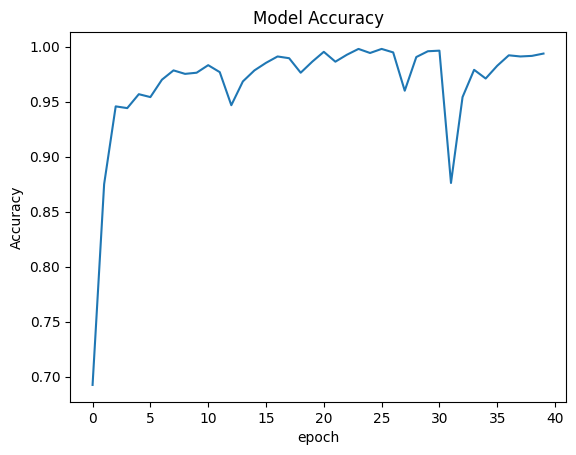

In [ ]:
def plot_hist(hist):
  plt.plot(hist.history["accuracy"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("epoch")
  plt.show()

plot_hist(hist)

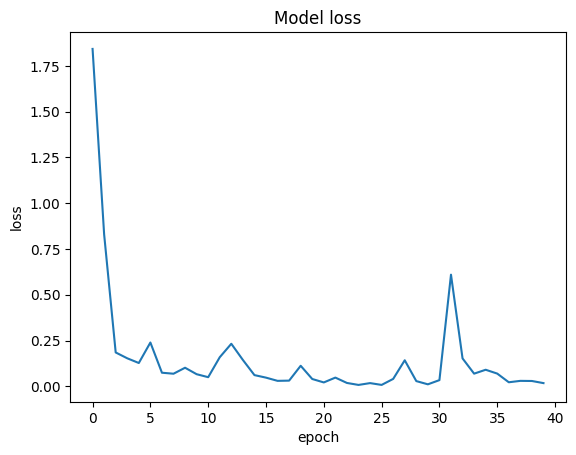

In [ ]:
def plot_hist(hist):
  plt.plot(hist.history["loss"])
  plt.title("Model loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.show()

plot_hist(hist)

In [ ]:
preds = model.evaluate(test_x, test_y)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

20/20 [==============================] - 5s 123ms/step - loss: 0.0542 - accuracy: 0.9826
Loss = 0.0541725717484951
Test Accuracy = 0.9826224446296692


In [ ]:
y_predicted = model.predict(test_x)
y_predicted[0]

20/20 [==============================] - 3s 59ms/step


array([1.2447151e-05, 5.2807718e-09, 9.9998760e-01], dtype=float32)

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels[:5]

[2, 0, 0, 0, 2]

In [ ]:
test_y_labels = [np.argmax(i) for i in test_y]
test_y_labels[:5]

[2, 0, 0, 0, 2]

In [ ]:
cm = tf.math.confusion_matrix(labels = test_y_labels, predictions = y_predicted_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[236,   0,   1],
       [  0, 109,   0],
       [ 10,   0, 277]], dtype=int32)>

Text(95.72222222222221, 0.5, 'True')

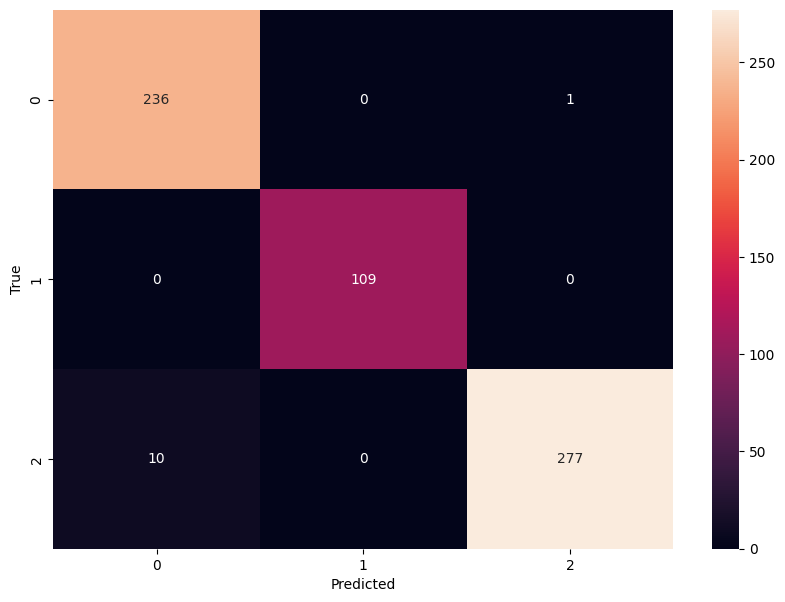

In [ ]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True')